In [1]:
%matplotlib inline
#%matplotlib ipympl
%load_ext autoreload
%autoreload 2
from pylab import *
import pandas as pd

In [2]:
#Define a function to load the data
def load_data(start,end,ch,name="OKSeq",root="../data_hela/"):
    #Start and end are in kb
    #return x in kb and signalvalue
    
    data = {"OKSeq":"OKSeq_5kb.csv",
            "MRT":"MRT_10kb.csv",
            "Ori":"ori_position.tsv"}
    
    if "tsv" in data[name]:
        sep="\t"
    else:
        sep=","
    
    read = pd.read_csv(root+data[name],sep=sep)
    #print(read.head())
    
    read = read[read.chrom=="chr%i"%ch]
    read = read[ (start<read.chromStart/1000) &  (read.chromStart/1000< end)]
    return np.array(read.chromStart)/1000,np.array(read.signalValue)
    

In [4]:
from repli1d.fast_sim_break import get_fast_MRT_RFDs

fork_speed= 1.5  # in kb / minute
ndiff=1.1  # Number of firing factors per Mb
Nsim = 200
binsize = 5 # in kb
dori = 5 # Average distance between origins in kb
noise_ratio = 0.05 # 15 percent of random activations 

startp=5000 # in kb
endp = 50000 # in kb
ch=1


genomic_position,ori = load_data(startp,endp,ch=ch,name="Ori") #Generate random profile
RandomActivation = np.ones_like(ori) * noise_ratio * np.sum(ori) / len(ori)  # Random activation
profile = ori+RandomActivation


#Rescaling parameters to size of simulated chromosome
kon = 1e-5 * 2875000 / (len(profile) * binsize ) #whole genome ( 2875000 == whole genome I am working with)
ndiff = int(ndiff * len(profile) * binsize / 1000)
print("%.1e ,NDiff %i"%(kon,ndiff))

data = get_fast_MRT_RFDs(Nsim,
                         profile,
                         ndiff,
                         kon=kon,
                         fork_speed=fork_speed / binsize, #Fork speed is rescaled in bin/minute
                         single_mol_exp=True,
                         pulse_size=5,
                         dori=dori,
                         return_dict=True,n_jobs=6)

6.4e-04 ,NDiff 49
EXperimental
Fs cte , dt 3.3 (min)
Average introduced 0.0
Maxiiiiiiiiiiiiiii 122


In [5]:
#All the data from the simulation
print(data.keys())
# mean_MRT_normed , mean_MRT_time #sef explanatory
# hist_MRT (resp hist_RFD) list of individual MRT (resp RFD)
# position_time_activated_oris: list of simu.
#                               for each simu it is a list with  [pos,time,unreplicated_DNA]
# proba_activation (res proba_termination) proba of activation by genomic bin (resp termination)

dict_keys(['mean_MRT_normed', 'MRTpstd', 'mean_MRT_time', 'hist_MRT', 'mean_RFD', 'hist_RFD', 'hist_replication_time', 'single_mol_exp', 'position_time_activated_oris', 'It', 'proba_activation', 'proba_termination', 'time'])


# Plot MRT average and two individuals mrt

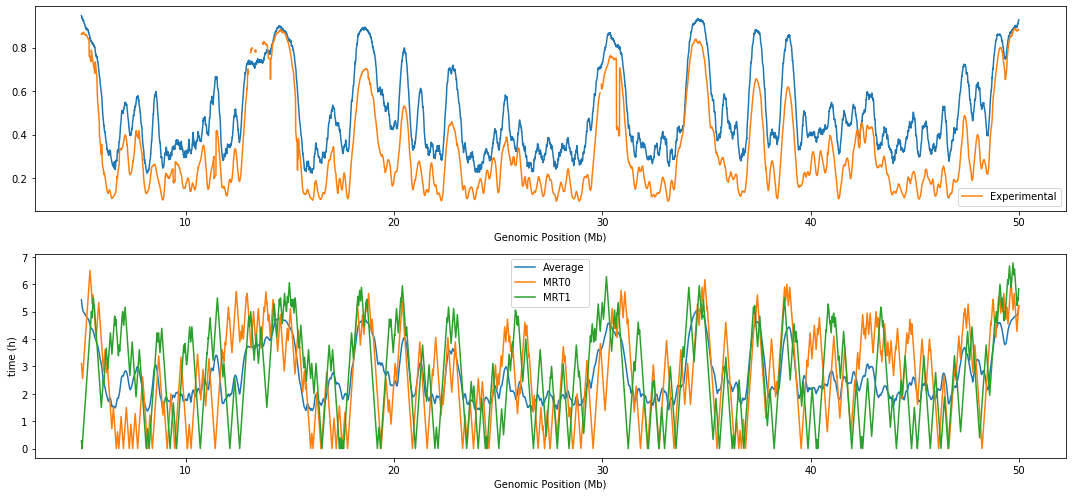

In [6]:
f = figure(figsize=(15,7))
f.add_subplot(211)
plot(genomic_position / 1000,data["mean_MRT_normed"])

genomic_position_mrt,MRT = load_data(startp,endp,ch,"MRT")
plot(genomic_position_mrt/1000,MRT,label="Experimental")
legend()

xlabel("Genomic Position (Mb)")
f.add_subplot(212)
plot(genomic_position / 1000,data["mean_MRT_time"]/60,label="Average")

#Plot two individual MRTs
plot(genomic_position / 1000,data["hist_MRT"][0]/60,label="MRT0")
plot(genomic_position / 1000,data["hist_MRT"][1]/60,label="MRT1")
legend(loc="best")
ylabel("time (h)")
xlabel("Genomic Position (Mb)")
f.tight_layout()



# Plot RFD

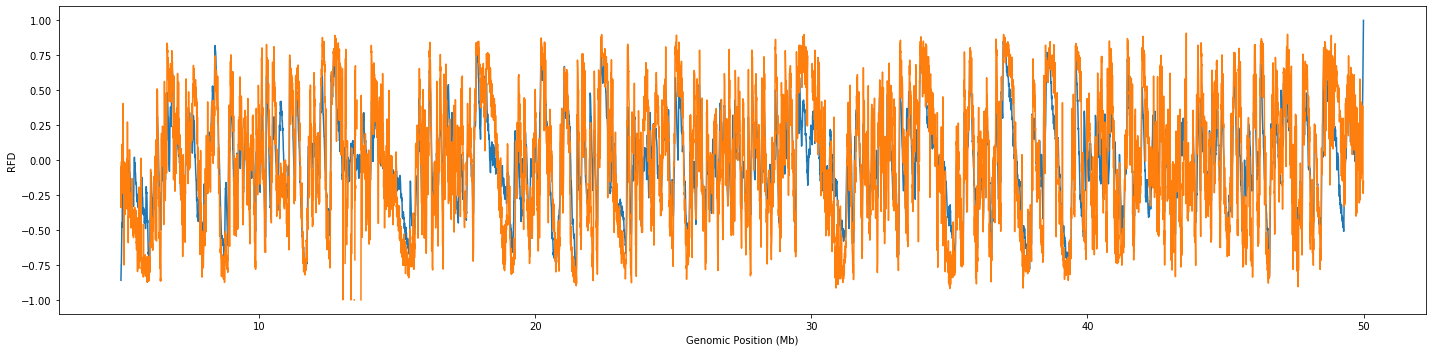

In [7]:
f = figure(figsize=(20,5))
plot(genomic_position/1000,data["mean_RFD"])

_,RFD = load_data(startp,endp,ch,"OKSeq")

plot(genomic_position/1000,RFD,label="Experimental")

xlabel("Genomic Position (Mb)")
ylabel("RFD")
f.tight_layout()

# I(t)

Text(0.5, 0, 'time (h)')

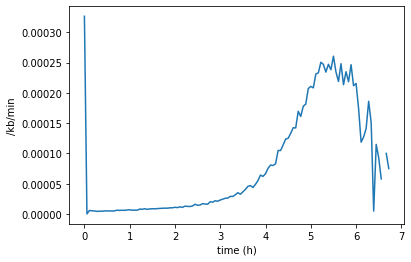

In [8]:
plot(data["time"] / 60,data["It"])
ylabel("/kb/min")
xlabel("time (h)")

# Single mol analysis

In [9]:
from repli1d.single_mol_analysis import compute_info, compute_real_inter_ori ,compute_mean_activated_ori

#Fiber 
fiber_size= 200 # in kb


# small function to format output
def trunc2(v):
    try:
        return float("%.2e" % v)
    except:
        return v

    
resolution = binsize
Deltas0 = compute_info(Sme=data["single_mol_exp"], size_single_mol=int(fiber_size/resolution), n_sample=200)

Res = {}

Res["Fiber200meaninterdist"] = trunc2(np.mean(np.concatenate(Deltas0["dist_ori"])*resolution))

print("Mean inter ori distance", np.mean(np.concatenate(Deltas0["dist_ori"])*resolution))

Deltas = compute_real_inter_ori(data["position_time_activated_oris"])
print("Mean real inter ori distance", np.mean(Deltas)*resolution)

Res["Realinterdist"] = trunc2(np.mean(Deltas)*resolution)


nfork_per_fiber = np.array([len(di) for di in Deltas0["size_forks"]])
# hist(nfork_per_fiber,range=[0,5],bins=6,normed=True)
for i in range(5):
    print("Nfork %i, percent %.2f" % (i, np.sum(nfork_per_fiber == i)/len(nfork_per_fiber)))

    Res["Fiber200_percent_%i_Forks" % i] = trunc2(np.sum(nfork_per_fiber == i)/len(nfork_per_fiber))

print("Mean number of fork / fiber having forks",
      np.mean(nfork_per_fiber[nfork_per_fiber != 0]))

Res["Nforkperfibrwithfork"] = trunc2(np.mean(nfork_per_fiber[nfork_per_fiber != 0]))

Mean inter ori distance 86.05721393034825
Mean real inter ori distance 212.97490911682942
Nfork 0, percent 0.63
Nfork 1, percent 0.17
Nfork 2, percent 0.13
Nfork 3, percent 0.02
Nfork 4, percent 0.03
Mean number of fork / fiber having forks 1.912921573339742
